In [1]:
import pandas
import numpy as np
from Bio import SeqIO
from scipy.sparse import csr_matrix
from sklearn.preprocessing import LabelBinarizer

import statsmodels as sm
import scipy

In [2]:
protein_groups = pandas.read_csv("proteinGroups.txt", sep="\t")
protein_groups = protein_groups.set_index("Gene names")

/home/andylane/Envs/MetAP/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (132) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


One issue: in some cases, the identity of a particular protein is ambiguous based on the peptides seen. Given that fact, they are not good true training examples. We will remove these from the analysis.

Number of proteins
1     4733
2      292
3       64
4       11
5        4
6        5
7        2
10       1
11       3
13       1
15       1
42       1
Name: Protein IDs, dtype: int64

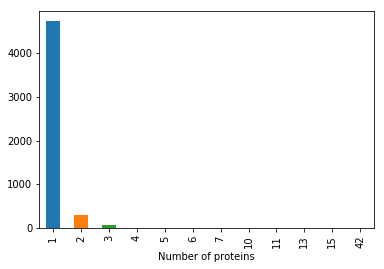

In [3]:
%matplotlib inline
protein_groups.groupby("Number of proteins").count()["Protein IDs"].plot.bar()
protein_groups.groupby("Number of proteins").count()["Protein IDs"]

In [4]:
# Take only the proteins where:

# We are certain what protein we're looking at
protein_groups = protein_groups.loc[protein_groups["Number of proteins"] == 1]
# This reduces the number of examples from 5118 to 4733

# There is an iBAQ value calculated in all conditions
protein_groups = protein_groups.loc[protein_groups.filter(like = "iBAQ ").min(axis=1) > 0]
print(protein_groups.loc[protein_groups.filter(like = "iBAQ ").min(axis=1) > 0].count()["Protein IDs"])
# This further reduces the number of examples to 3436

3436


In [5]:
# Compile the IDs of the remaining proteins for submission to ENSEMBL to get sequences

protein_ids = open("protein_ids.txt", "w")

for i in protein_groups["Majority protein IDs"]:
    individual = i.split(";")
    for j in individual:
        protein_ids.write(j)
        protein_ids.write("\n")

After manually downloading from UniProt, 2337 sequences matched on ID. Some of this is due to things like control 
and contaminant protein IDs not matching any true UniProt ID.

Reduce dimensionality by encoding residues by properties

In [6]:
def summarize_sidechain(protein):
    summarized_sidechains = []
    for amino_acid in protein:
        if amino_acid in "RHK":
            summarized_sidechains.append("+")
        elif amino_acid in "DE": # -
            summarized_sidechains.append("-")
        elif amino_acid in "STNQ": # o polar uncharged
            summarized_sidechains.append("o")
        elif amino_acid in "CUGP": # ~ "special"
            summarized_sidechains.append("~")
        elif amino_acid in "AVILMFYW": # p hydrophobic
            summarized_sidechains.append("p")
    return "".join(summarized_sidechains)

aa_summaries = ["+", "-", "o", "~", "p"]

One-hot encode k-mers in protein sequences

In [7]:
proteins = SeqIO.parse("protein_sequences.fasta", format="fasta")
proteins = list(proteins)

In [8]:
def kmerize(proteinseq, kmersize):
    '''
    A function to generate overlapping kmersize kmers from a protein
    '''
    kmers = []
    for index, residue in enumerate(proteinseq):
        if index <= len(proteinseq) - kmersize: #Stop at last complete kmer
            kmers.append(proteinseq[index:index+kmersize])
    return kmers

In [9]:
for p in proteins:
    p.summ = summarize_sidechain(str(p.seq))

In [10]:
# Generate the binarization factors - all k-mers seen in the input dataset
all_kmers = []
for protein in proteins:
    all_kmers.extend(kmerize(str(protein.summ),4 ))
kmers = set(all_kmers)
kmers = list(kmers)

# Fit a binary
binarizer = LabelBinarizer(sparse_output=True)
binarizer.fit(kmers)

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=True)

In [11]:
# proteins = SeqIO.parse("protein_sequences.fasta", format="fasta")
kmerized = []
for protein in proteins:
    kmer_per_protein = kmerize(str(protein.summ)[:15],4)
    kmerized.append(
        {
            "name": protein.name.split("|")[1],
            "kmers": kmer_per_protein,
            "vectorized": binarizer.transform(kmer_per_protein)
        }
                   )
    

In [12]:
# pickle.dump(kmerized, open("kmerized_dict_binarized.pkl", "wb"))

In [13]:
import pickle as pkl
# kmerized = pkl.load(open("kmerized_dict_binarized.pkl", "rb"))

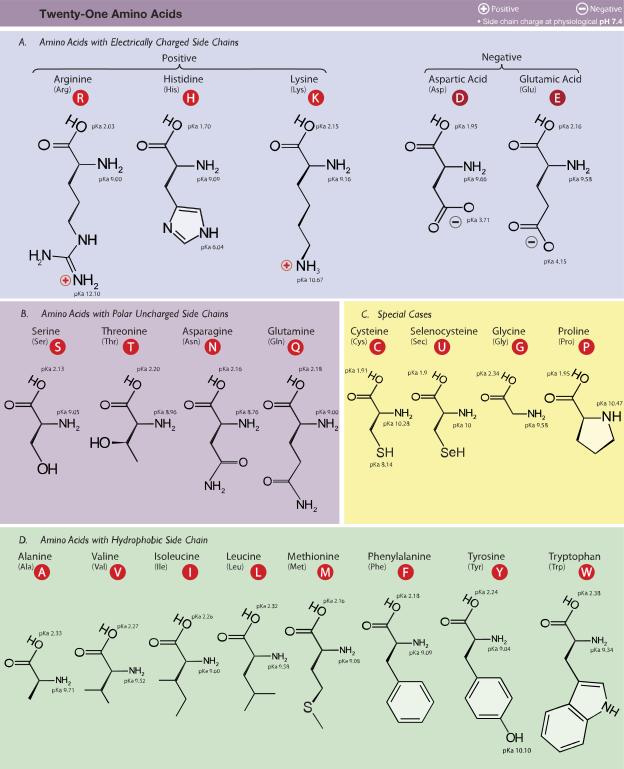

In [14]:
labels = binarizer.classes_

In [15]:
labels

array(['++++', '+++-', '+++o', '+++p', '+++~', '++-+', '++--', '++-o',
       '++-p', '++-~', '++o+', '++o-', '++oo', '++op', '++o~', '++p+',
       '++p-', '++po', '++pp', '++p~', '++~+', '++~-', '++~o', '++~p',
       '++~~', '+-++', '+-+-', '+-+o', '+-+p', '+-+~', '+--+', '+---',
       '+--o', '+--p', '+--~', '+-o+', '+-o-', '+-oo', '+-op', '+-o~',
       '+-p+', '+-p-', '+-po', '+-pp', '+-p~', '+-~+', '+-~-', '+-~o',
       '+-~p', '+-~~', '+o++', '+o+-', '+o+o', '+o+p', '+o+~', '+o-+',
       '+o--', '+o-o', '+o-p', '+o-~', '+oo+', '+oo-', '+ooo', '+oop',
       '+oo~', '+op+', '+op-', '+opo', '+opp', '+op~', '+o~+', '+o~-',
       '+o~o', '+o~p', '+o~~', '+p++', '+p+-', '+p+o', '+p+p', '+p+~',
       '+p-+', '+p--', '+p-o', '+p-p', '+p-~', '+po+', '+po-', '+poo',
       '+pop', '+po~', '+pp+', '+pp-', '+ppo', '+ppp', '+pp~', '+p~+',
       '+p~-', '+p~o', '+p~p', '+p~~', '+~++', '+~+-', '+~+o', '+~+p',
       '+~+~', '+~-+', '+~--', '+~-o', '+~-p', '+~-~', '+~o+', '+~o-',
      

In [16]:
# Flattens the array to a single row of counts
binarized_protein = []
for protein in kmerized:
    binarized_protein.append(
    {
        "binarized": csr_matrix(np.sum(protein["vectorized"][:], axis=0)),
        "name": protein["name"]
    })

Calculate log-ratio of expression, where n is number of replicates, G(ij) is test gene j expression in sample i, R(ij) is control gene j expression in sample i. 

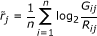

Or proportion as defined in:
https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-12-228

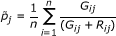

In [17]:
binarized_protein

[{'binarized': <1x625 sparse matrix of type '<class 'numpy.int64'>'
  	with 12 stored elements in Compressed Sparse Row format>, 'name': 'A0AVT1'},
 {'binarized': <1x625 sparse matrix of type '<class 'numpy.int64'>'
  	with 12 stored elements in Compressed Sparse Row format>, 'name': 'A0FGR8'},
 {'binarized': <1x625 sparse matrix of type '<class 'numpy.int64'>'
  	with 12 stored elements in Compressed Sparse Row format>, 'name': 'A0MZ66'},
 {'binarized': <1x625 sparse matrix of type '<class 'numpy.int64'>'
  	with 12 stored elements in Compressed Sparse Row format>, 'name': 'A1L020'},
 {'binarized': <1x625 sparse matrix of type '<class 'numpy.int64'>'
  	with 12 stored elements in Compressed Sparse Row format>, 'name': 'A1L0T0'},
 {'binarized': <1x625 sparse matrix of type '<class 'numpy.int64'>'
  	with 12 stored elements in Compressed Sparse Row format>, 'name': 'A2RRP1'},
 {'binarized': <1x625 sparse matrix of type '<class 'numpy.int64'>'
  	with 10 stored elements in Compressed Spa

In [18]:
protein_groups.iloc[:,93:117] = protein_groups.iloc[:,93:117].astype(float) # These are the columns with the LFQs

In [19]:
protein_groups.iloc[:,93:105].columns

Index(['iBAQ HAP1-wt-Bio1', 'iBAQ HAP1-wt-Bio2', 'iBAQ HAP1-wt-Bio3',
       'iBAQ HAP1-wt-Inh-Bio1', 'iBAQ HAP1-wt-Inh-Bio2',
       'iBAQ HAP1-wt-Inh-Bio3', 'iBAQ MetAP1-Bio1', 'iBAQ MetAP1-Bio2',
       'iBAQ MetAP1-Bio3', 'iBAQ MetAP1-Inh-Bio1', 'iBAQ MetAP1-Inh-Bio2',
       'iBAQ MetAP1-Inh-Bio3'],
      dtype='object')

In [20]:
protein_groups.iloc[:,105:117].columns

Index(['LFQ intensity HAP1-wt-Bio1', 'LFQ intensity HAP1-wt-Bio2',
       'LFQ intensity HAP1-wt-Bio3', 'LFQ intensity HAP1-wt-Inh-Bio1',
       'LFQ intensity HAP1-wt-Inh-Bio2', 'LFQ intensity HAP1-wt-Inh-Bio3',
       'LFQ intensity MetAP1-Bio1', 'LFQ intensity MetAP1-Bio2',
       'LFQ intensity MetAP1-Bio3', 'LFQ intensity MetAP1-Inh-Bio1',
       'LFQ intensity MetAP1-Inh-Bio2', 'LFQ intensity MetAP1-Inh-Bio3'],
      dtype='object')

In [21]:
import statsmodels.api as statmodels

/home/andylane/Envs/MetAP/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [22]:
corr_matrix = np.corrcoef(np.array(protein_groups.iloc[:,93]), np.array(protein_groups.iloc[:,105]))
statsmodels.graphics.correlation.plot_corr(corr_matrix)


NameError: name 'statsmodels' is not defined

In [23]:
np.mean(protein_groups["LFQ intensity HAP1-wt-Bio1"])/1e6

1003.8608658614668

In [24]:
np.mean(protein_groups["iBAQ HAP1-wt-Bio1"])/1e6

54.12048765541327

In [25]:
# Next get out the condition and LFQ data for each protein
def proportion(evidence, normalize=True):
    mean_unperturbed_LFQ = \
     (evidence["LFQ intensity HAP1-wt-Bio1"].iat[0] + \
     evidence["LFQ intensity HAP1-wt-Bio2"].iat[0] +\
     evidence["LFQ intensity HAP1-wt-Bio3"].iat[0]) /3
    def inner_proportion(replicates):
        proportions = []
        for measurement in replicates:
            proportions.append(
                              evidence[measurement].iat[0] + 1 / 
                               (mean_unperturbed_LFQ + 1 +
                               evidence[measurement].iat[0]))
#         print(evidence)
        return np.mean(proportions)
        
    
    result = {"HAP1wt": inner_proportion(["LFQ intensity HAP1-wt-Bio1", 
                                        "LFQ intensity HAP1-wt-Bio2", 
                                        "LFQ intensity HAP1-wt-Bio3"]),
            "HAP1wtInh": inner_proportion(["LFQ intensity HAP1-wt-Inh-Bio1", 
                                        "LFQ intensity HAP1-wt-Inh-Bio2", 
                                        "LFQ intensity HAP1-wt-Inh-Bio3"]),
            "MetAP1": inner_proportion(["LFQ intensity MetAP1-Bio1", 
                                        "LFQ intensity MetAP1-Bio2", 
                                        "LFQ intensity MetAP1-Bio3"]),
            "MetAP1Inh": inner_proportion(["LFQ intensity MetAP1-Inh-Bio1", 
                                        "LFQ intensity MetAP1-Inh-Bio2", 
                                        "LFQ intensity MetAP1-Inh-Bio3"])
           }
    
    if normalize == True:
        unperturbed_proportion = result["HAP1wt"]
        for condition, value in result.items():
            try:
                result[condition] = np.log2(value/unperturbed_proportion)
            except:
                result = None
                return result
        return result


def mean(evidence):
    def inner_mean(replicates):
        lfqs = []
        for measurement in replicates:
            lfqs.append(evidence[measurement].iat[0])
        return np.mean(lfqs)
    
    return {"HAP1wt": inner_mean(["LFQ intensity HAP1-wt-Bio1", 
                                        "LFQ intensity HAP1-wt-Bio2", 
                                        "LFQ intensity HAP1-wt-Bio3"]),
            "HAP1wtInh": inner_mean(["LFQ intensity HAP1-wt-Inh-Bio1", 
                                        "LFQ intensity HAP1-wt-Inh-Bio2", 
                                        "LFQ intensity HAP1-wt-Inh-Bio3"]),
            "MetAP1": inner_mean(["LFQ intensity MetAP1-Bio1", 
                                        "LFQ intensity MetAP1-Bio2", 
                                        "LFQ intensity MetAP1-Bio3"]),
            "MetAP1Inh": inner_mean(["LFQ intensity MetAP1-Inh-Bio1", 
                                        "LFQ intensity MetAP1-Inh-Bio2", 
                                        "LFQ intensity MetAP1-Inh-Bio3"])
           }

def process_for_proportion(binarized_protein):
    training_data = []
    for index, protein in enumerate(binarized_protein):
        try:
            # Get the corresponding row
            evidence = protein_groups[protein_groups["Majority protein IDs"].str.contains(pat=protein["name"])]
            # convert the LFQs to a proportion of control WT/unperturbed    
            protein["lfq"] = proportion(evidence)
            if protein["lfq"] is not None:
                training_data.append(protein)
        except:
            print(protein["name"])
#             raise
    return training_data

def process_for_mean(binarized_protein):
    training_data = []
    for index, protein in enumerate(binarized_protein):
        try:
            # Get the corresponding row
            evidence = protein_groups[protein_groups["Majority protein IDs"].str.contains(pat=protein["name"])]
            # convert the LFQs to a proportion of control WT/unperturbed    
            protein["lfq"] = mean(evidence)
            training_data.append(protein)
        except:
            raise
#             print(protein["name"])
        return training_data

In [26]:
# Next get out the condition and LFQ data for each protein
def proportion_ibaq(evidence, normalize=True, logratio=True):
    mean_unperturbed_IBAQ = \
     (evidence.iloc[:,93].iat[0] + \
     evidence.iloc[:,94].iat[0] + \
     evidence.iloc[:,95].iat[0]) /3
#     def inner_proportion(replicates):
#         proportions = []
#         for measurement in replicates:
#             proportions.append(
#                               evidence.iloc[:,measurement].iat[0] / 
#                                (mean_unperturbed_IBAQ + 1 +
#                                evidence.iloc[:,measurement].iat[0]))
# #         print(evidence["Majority protein IDs"])
#         return np.mean(proportions)
        
    def logratio(replicates):
        logratios = []
        for measurement in replicates:
            logratios.append(np.log2(evidence.iloc[:,measurement].iat[0] / 
                               mean_unperturbed_IBAQ))
        return np.mean(logratios)
                
#     if logratio==False:
#         result = {"HAP1wt": inner_proportion([93, 94, 95]), # column numbers for relevant iBAQ
#                 "HAP1wtInh": inner_proportion([96, 97, 98]),
#                 "MetAP1": inner_proportion([99, 100, 101]),
#                 "MetAP1Inh": inner_proportion([102, 103, 104])
#                }
    
#     if logratio == True:
    result = {"HAP1wt": logratio([93, 94, 95]), # column numbers for relevant iBAQ
    "HAP1wtInh": logratio([96, 97, 98]),
    "MetAP1": logratio([99, 100, 101]),
    "MetAP1Inh": logratio([102, 103, 104])
   }
    print('hey')
    return result

    
#     if normalize == True:
#         unperturbed_proportion = result["HAP1wt"]
#         for condition, value in result.items():
#             try:
#                 result[condition] = np.log2(value/unperturbed_proportion)
#             except:
#                 result = None
#                 return result
#         return result




def process_for_proportion_ibaq(binarized_protein, normalize=True, logratio=False):
    training_data = []
    for index, protein in enumerate(binarized_protein):
        try:
            # Get the corresponding row
            evidence = protein_groups[protein_groups["Majority protein IDs"].str.contains(pat=protein["name"])]
            # convert the LFQs to a proportion of control WT/unperturbed    
            protein["ibaq"] = proportion_ibaq(evidence, normalize=False, logratio=True)
            print(protein["ibaq"])
            if protein["ibaq"] is not None:
                training_data.append(protein)
        except:
            print(protein["name"])
    return training_data

A few proteins are not represented in the downloaded protein sequences; their protein ids are
output below.

Our data are in easily human-understandable dictionaries at this point. 
Next, slice out the relevant data. Here X is how many times we see each kmer in 
each protein and y is the relative abundance change of that protein in the MetAP1
mutant cells relative to the control cells (which happen to be haploid for MetAP1 in this case).

In [27]:
training_data = process_for_proportion_ibaq(binarized_protein, normalize=False, logratio=True)

hey
{'HAP1wt': -0.028091664846836534, 'HAP1wtInh': -0.010006398008214198, 'MetAP1': 0.5974601615974516, 'MetAP1Inh': 0.35656717952279465}
hey
{'HAP1wt': -0.2852880015229884, 'HAP1wtInh': -1.752707571666079, 'MetAP1': 0.8376429190588978, 'MetAP1Inh': -0.32146763482241375}
hey
{'HAP1wt': -0.04456050167051754, 'HAP1wtInh': 0.0073134741229958266, 'MetAP1': 1.5376250429374645, 'MetAP1Inh': 0.9656886076802046}
hey
{'HAP1wt': -0.1899320806391722, 'HAP1wtInh': -0.5158074739546118, 'MetAP1': 0.18787982616654708, 'MetAP1Inh': 0.4377745356718479}
hey
{'HAP1wt': -0.018372799433504394, 'HAP1wtInh': -0.10514353458526728, 'MetAP1': -0.06377977201969148, 'MetAP1Inh': -0.9877072354689719}
hey
{'HAP1wt': -0.1467340442921839, 'HAP1wtInh': 0.04896483207269476, 'MetAP1': 0.7821870305679791, 'MetAP1Inh': 0.05843695320380846}
hey
{'HAP1wt': -0.01104299745353262, 'HAP1wtInh': 0.5246302945265481, 'MetAP1': 0.49617080301093236, 'MetAP1Inh': 0.24278747372344553}
hey
{'HAP1wt': -0.0035212672839322334, 'HAP1wtInh'

hey
{'HAP1wt': -0.026479374924766763, 'HAP1wtInh': -0.11386165479417838, 'MetAP1': 0.6641072505142381, 'MetAP1Inh': 0.2991744875021508}
hey
{'HAP1wt': -0.010160246249662256, 'HAP1wtInh': -0.05271311077041189, 'MetAP1': 0.6410365670324735, 'MetAP1Inh': 0.30583177278922974}
hey
{'HAP1wt': -0.23203480475304547, 'HAP1wtInh': -0.057876747923351894, 'MetAP1': 1.284675968369833, 'MetAP1Inh': 0.5002080568838435}
hey
{'HAP1wt': -0.0559889909961838, 'HAP1wtInh': -0.44073159237777465, 'MetAP1': 1.2559366814080082, 'MetAP1Inh': 0.5556607777917385}
hey
{'HAP1wt': -0.044536280903999616, 'HAP1wtInh': -0.38177310703101597, 'MetAP1': 0.3403499506394933, 'MetAP1Inh': 0.24539858958149233}
hey
{'HAP1wt': -0.03036606069365938, 'HAP1wtInh': 0.6195255618158603, 'MetAP1': 0.7965576421665043, 'MetAP1Inh': 0.36823172456676745}
hey
{'HAP1wt': -0.2437794073481725, 'HAP1wtInh': -2.214058559765228, 'MetAP1': -2.160416258899313, 'MetAP1Inh': -2.129493506828677}
hey
{'HAP1wt': -0.159509623749827, 'HAP1wtInh': -0.0828

hey
{'HAP1wt': -0.04383866630030706, 'HAP1wtInh': 0.13289055059074262, 'MetAP1': 0.7687889406772556, 'MetAP1Inh': 0.4128283911067343}
hey
{'HAP1wt': -0.07203338080767259, 'HAP1wtInh': 0.7707685517086477, 'MetAP1': 1.147065812033662, 'MetAP1Inh': 0.9543620544387625}
hey
{'HAP1wt': -0.033609360478007964, 'HAP1wtInh': -0.6031571973275004, 'MetAP1': -0.10900138836709787, 'MetAP1Inh': -2.117884288151712}
hey
{'HAP1wt': -0.22331709775293226, 'HAP1wtInh': -0.1816888208843013, 'MetAP1': 0.5305569612812316, 'MetAP1Inh': -0.22349438245225808}
hey
{'HAP1wt': -0.05431928219745317, 'HAP1wtInh': 0.1588969926550088, 'MetAP1': 0.4296888836362868, 'MetAP1Inh': -0.12087868463244279}
hey
{'HAP1wt': -0.24174477568715988, 'HAP1wtInh': -0.13817842524434562, 'MetAP1': 0.510643852202304, 'MetAP1Inh': -0.02958878428216984}
hey
{'HAP1wt': -0.22353283355850637, 'HAP1wtInh': -0.47226636594028043, 'MetAP1': 0.1274377435100047, 'MetAP1Inh': -0.9455228183961369}
hey
{'HAP1wt': -0.050559799227532676, 'HAP1wtInh': -0.

hey
{'HAP1wt': -0.004753349652874289, 'HAP1wtInh': -0.10128116877133007, 'MetAP1': 0.41386808238187484, 'MetAP1Inh': -0.6523963205058174}
hey
{'HAP1wt': -0.1250538975407107, 'HAP1wtInh': 0.569856195244424, 'MetAP1': 0.589414735284799, 'MetAP1Inh': -0.12723707583752697}
hey
{'HAP1wt': -0.039224192855519834, 'HAP1wtInh': -0.43145998774366295, 'MetAP1': 0.6292507774700661, 'MetAP1Inh': 0.05585286118464553}
hey
{'HAP1wt': -0.36981503638252117, 'HAP1wtInh': 0.42038844518703583, 'MetAP1': 0.8372871226810057, 'MetAP1Inh': 0.11504448879911588}
hey
{'HAP1wt': -0.048093439263083966, 'HAP1wtInh': 0.031672948869709595, 'MetAP1': 0.5720826081321042, 'MetAP1Inh': 0.382455657858279}
hey
{'HAP1wt': -0.0050044000258743825, 'HAP1wtInh': 0.004587258858765773, 'MetAP1': 0.38312492835594436, 'MetAP1Inh': 0.09398653693168883}
hey
{'HAP1wt': -0.054749716707887815, 'HAP1wtInh': -0.32056279899182105, 'MetAP1': -0.10613288192682695, 'MetAP1Inh': -0.5543457978038945}
hey
{'HAP1wt': -0.04801454640139932, 'HAP1wtI

hey
{'HAP1wt': -0.191776583216182, 'HAP1wtInh': 0.18225600081736767, 'MetAP1': 0.7145366125931721, 'MetAP1Inh': 0.029099316692938082}
hey
{'HAP1wt': -0.1267441464311632, 'HAP1wtInh': -0.06900493036074844, 'MetAP1': 0.2906770968891588, 'MetAP1Inh': -0.3142805077864544}
hey
{'HAP1wt': -0.018064045382847903, 'HAP1wtInh': 0.18282443102799859, 'MetAP1': 0.444646519540231, 'MetAP1Inh': 0.07579571426880416}
hey
{'HAP1wt': -0.2529043053558691, 'HAP1wtInh': 0.30742880773880477, 'MetAP1': 0.6223294189319256, 'MetAP1Inh': 0.014301914031101204}
hey
{'HAP1wt': -0.07935028692775074, 'HAP1wtInh': -0.39313294337596005, 'MetAP1': -0.6511894337713603, 'MetAP1Inh': -0.39301215767347036}
hey
{'HAP1wt': -0.030975203269304235, 'HAP1wtInh': 0.15562139579318934, 'MetAP1': 0.4255357443291685, 'MetAP1Inh': -0.14926376419827758}
hey
{'HAP1wt': -0.059236235327362906, 'HAP1wtInh': -0.6397041885796729, 'MetAP1': 0.5065487303311794, 'MetAP1Inh': -0.5988296476463812}
hey
{'HAP1wt': -0.8279117682600988, 'HAP1wtInh': -

hey
{'HAP1wt': -0.1591432445244563, 'HAP1wtInh': 0.029577522141164936, 'MetAP1': -0.6996614066879898, 'MetAP1Inh': -0.6920398589731954}
hey
{'HAP1wt': -0.10600007554597994, 'HAP1wtInh': 0.2850925833502923, 'MetAP1': -0.018586696912273215, 'MetAP1Inh': 0.32663367914140534}
hey
{'HAP1wt': -0.04762233845963417, 'HAP1wtInh': -0.6068423537737261, 'MetAP1': 1.0263902122473536, 'MetAP1Inh': 0.8107751070093618}
hey
{'HAP1wt': -0.04377714922912613, 'HAP1wtInh': -0.2362005930130254, 'MetAP1': -0.5443274133352229, 'MetAP1Inh': 0.10141003319999707}
hey
{'HAP1wt': -0.005033444639842473, 'HAP1wtInh': 0.3883668538863911, 'MetAP1': 1.194973579411603, 'MetAP1Inh': 0.3832043041204918}
hey
{'HAP1wt': -0.13433895605703874, 'HAP1wtInh': 0.1027020985282686, 'MetAP1': 0.7535531621793332, 'MetAP1Inh': 0.6772013033541597}
hey
{'HAP1wt': -0.01434508360617632, 'HAP1wtInh': -0.7853340028568155, 'MetAP1': 0.8113177741765627, 'MetAP1Inh': -0.9359478122930606}
hey
{'HAP1wt': -0.05702122631634765, 'HAP1wtInh': -0.497

hey
{'HAP1wt': -0.240485858780804, 'HAP1wtInh': 0.07595284496453972, 'MetAP1': 0.6870257674490144, 'MetAP1Inh': 0.14390934664257757}
hey
{'HAP1wt': -0.3460850883371876, 'HAP1wtInh': 0.23650286136243306, 'MetAP1': 1.2292257985291328, 'MetAP1Inh': 0.7334671485113057}
hey
{'HAP1wt': -0.00954538257747447, 'HAP1wtInh': -0.12036185570709401, 'MetAP1': 0.8016845029071594, 'MetAP1Inh': 0.3974036816045665}
hey
{'HAP1wt': -0.01944543875525327, 'HAP1wtInh': -0.27208279381391054, 'MetAP1': -0.03836721560620263, 'MetAP1Inh': -0.8841144805047629}
hey
{'HAP1wt': -0.05462043571018796, 'HAP1wtInh': 0.05396159863083564, 'MetAP1': 0.8066823720087236, 'MetAP1Inh': 0.2680110822807789}
hey
{'HAP1wt': -0.04959716480495751, 'HAP1wtInh': -0.5139915313549782, 'MetAP1': 0.11018397016406434, 'MetAP1Inh': -0.8410170881973164}
hey
{'HAP1wt': -0.02017280452253271, 'HAP1wtInh': -0.012640871669032853, 'MetAP1': 0.3311997003883396, 'MetAP1Inh': -0.09015554897054723}
hey
{'HAP1wt': -0.043745644802645596, 'HAP1wtInh': -0

hey
{'HAP1wt': -0.06884561571235087, 'HAP1wtInh': 0.02950100088303279, 'MetAP1': 0.0788474683616419, 'MetAP1Inh': -0.5222478675119512}
hey
{'HAP1wt': -0.035443089248728604, 'HAP1wtInh': -0.5215603605941946, 'MetAP1': -0.47840094769904384, 'MetAP1Inh': -1.015248109437408}
hey
{'HAP1wt': -0.049842125799148616, 'HAP1wtInh': 0.22608044576544706, 'MetAP1': 0.6988938335792715, 'MetAP1Inh': 0.19662449824255138}
hey
{'HAP1wt': -0.2000157485302516, 'HAP1wtInh': -0.40107210996683973, 'MetAP1': 0.1959215466812451, 'MetAP1Inh': -0.33961337775791556}
hey
{'HAP1wt': -0.05709115805687898, 'HAP1wtInh': -0.18219931748644913, 'MetAP1': 0.14353273657508872, 'MetAP1Inh': -0.3559282092315416}
hey
{'HAP1wt': -0.2957140123641435, 'HAP1wtInh': -1.5902415335654878, 'MetAP1': 0.4813202222637519, 'MetAP1Inh': -0.5324215014497276}
hey
{'HAP1wt': -0.033843681267051284, 'HAP1wtInh': -0.01130341988245473, 'MetAP1': 0.5579220551395662, 'MetAP1Inh': 0.23924213410551365}
hey
{'HAP1wt': -0.3348349261950763, 'HAP1wtInh':

hey
{'HAP1wt': -0.025867890822039663, 'HAP1wtInh': -0.16738629016072895, 'MetAP1': 0.11462073479978906, 'MetAP1Inh': -0.39813594079204395}
hey
{'HAP1wt': -0.024129439203130803, 'HAP1wtInh': 0.1795712994101668, 'MetAP1': 0.8319766741247466, 'MetAP1Inh': 0.4879626002865569}
hey
{'HAP1wt': -0.08151705129602645, 'HAP1wtInh': -0.11293300640681825, 'MetAP1': 0.6832387192605577, 'MetAP1Inh': -0.4944559893872857}
hey
{'HAP1wt': -0.5866143821342678, 'HAP1wtInh': -0.5442416782812337, 'MetAP1': 0.17393988776124858, 'MetAP1Inh': -0.3630885249180553}
hey
{'HAP1wt': -0.14016669268274973, 'HAP1wtInh': -1.0478545611107852, 'MetAP1': 0.15860624182248342, 'MetAP1Inh': -0.3026867572930769}
hey
{'HAP1wt': -1.2102766685011004, 'HAP1wtInh': -2.0274491531862435, 'MetAP1': 0.2705568220152933, 'MetAP1Inh': -2.10201368361827}
hey
{'HAP1wt': -0.7313867021640409, 'HAP1wtInh': -3.2617142368190444, 'MetAP1': 0.6471826371268651, 'MetAP1Inh': 1.3960442557221844}
hey
{'HAP1wt': -0.019199390591360877, 'HAP1wtInh': -0.0

hey
{'HAP1wt': -0.03588789667130008, 'HAP1wtInh': -0.012073460073870815, 'MetAP1': 0.9419974625436979, 'MetAP1Inh': 0.4308939595666836}
hey
{'HAP1wt': -0.03801050446306026, 'HAP1wtInh': -0.03005106348188311, 'MetAP1': 0.6243506338347155, 'MetAP1Inh': 0.09055496209229918}
hey
{'HAP1wt': -0.04448142646965286, 'HAP1wtInh': -0.0343903894684566, 'MetAP1': 0.8271101103963231, 'MetAP1Inh': 0.2954449307902602}
hey
{'HAP1wt': -0.3054334077920657, 'HAP1wtInh': -0.3057250914506152, 'MetAP1': -0.5755092880579938, 'MetAP1Inh': 0.453504252570678}
hey
{'HAP1wt': -0.1520056004549225, 'HAP1wtInh': -0.3350427393143877, 'MetAP1': -0.58519378090659, 'MetAP1Inh': -1.2504145440372714}
hey
{'HAP1wt': -0.630418244501641, 'HAP1wtInh': -1.3500107384043265, 'MetAP1': -2.082023610562341, 'MetAP1Inh': -2.344774326501188}
hey
{'HAP1wt': -0.024930400697461597, 'HAP1wtInh': 0.06510757881612217, 'MetAP1': 0.7839337695465, 'MetAP1Inh': 0.3034571769875647}
hey
{'HAP1wt': -0.009210010431612731, 'HAP1wtInh': 0.14378708775

hey
{'HAP1wt': -0.13102142897953636, 'HAP1wtInh': -0.2678502861294381, 'MetAP1': 0.47544667177368954, 'MetAP1Inh': 0.15300011905876273}
hey
{'HAP1wt': -0.0618785041558661, 'HAP1wtInh': 0.6372915929423412, 'MetAP1': 0.3789752756273244, 'MetAP1Inh': 0.6799553839963841}
hey
{'HAP1wt': -0.5046024810392064, 'HAP1wtInh': -0.17848615333544057, 'MetAP1': 0.7999120748009663, 'MetAP1Inh': -0.3824168763347758}
hey
{'HAP1wt': -0.10059545541017674, 'HAP1wtInh': -0.8673817030512235, 'MetAP1': -0.41957838903518674, 'MetAP1Inh': -1.1242387955697761}
hey
{'HAP1wt': -0.23012786834553223, 'HAP1wtInh': 0.4560864813435745, 'MetAP1': 0.5945023823548333, 'MetAP1Inh': -0.45290185014579026}
hey
{'HAP1wt': -0.03274666881936165, 'HAP1wtInh': 0.1116529468788896, 'MetAP1': 1.677880577306378, 'MetAP1Inh': 0.9808834091979518}
hey
{'HAP1wt': -0.019219337024012472, 'HAP1wtInh': -0.05624269857135645, 'MetAP1': -0.14826266333614538, 'MetAP1Inh': -0.6549729308586533}
hey
{'HAP1wt': -0.048382171587127376, 'HAP1wtInh': -0.

hey
{'HAP1wt': -0.04466282242786037, 'HAP1wtInh': -0.051103384883714686, 'MetAP1': -0.3374623077798777, 'MetAP1Inh': -1.0504051300405937}
hey
{'HAP1wt': -0.12348156337549776, 'HAP1wtInh': -0.002780295914321946, 'MetAP1': 0.3310100303013895, 'MetAP1Inh': -0.07678322500897795}
hey
{'HAP1wt': -0.09914016294306427, 'HAP1wtInh': 0.2940153065396351, 'MetAP1': 0.3831231390985166, 'MetAP1Inh': -0.2218432699630176}
hey
{'HAP1wt': -0.40339229461275844, 'HAP1wtInh': -0.5615106304307066, 'MetAP1': 0.4435939916866742, 'MetAP1Inh': -0.5386354260898712}
hey
{'HAP1wt': -0.05178826413325166, 'HAP1wtInh': -0.05799703860877534, 'MetAP1': 0.6760110788045383, 'MetAP1Inh': 0.20140521244414678}
hey
{'HAP1wt': -0.09566159401353998, 'HAP1wtInh': 0.17049429155061654, 'MetAP1': 0.44523268982288183, 'MetAP1Inh': -0.4573054480548939}
hey
{'HAP1wt': -0.011497876603854337, 'HAP1wtInh': 0.10586553219515732, 'MetAP1': 1.8495480760328504, 'MetAP1Inh': 1.5483697742619107}
hey
{'HAP1wt': -0.10648158615577456, 'HAP1wtInh'

hey
{'HAP1wt': -0.05596335768990842, 'HAP1wtInh': 0.30963152128656074, 'MetAP1': 0.473745115027685, 'MetAP1Inh': -0.20550686617315597}
hey
{'HAP1wt': -0.046192839646356586, 'HAP1wtInh': -0.9850068045480925, 'MetAP1': 0.617059675540188, 'MetAP1Inh': -0.14421031736805487}
hey
{'HAP1wt': -0.28608291665018765, 'HAP1wtInh': 0.24184533145372478, 'MetAP1': 0.7464010234198875, 'MetAP1Inh': 0.32157289914413084}
hey
{'HAP1wt': -0.040980242430860424, 'HAP1wtInh': 0.1316078084336291, 'MetAP1': 0.2814837739768956, 'MetAP1Inh': -0.059382990189440654}
hey
{'HAP1wt': -0.01499815057594639, 'HAP1wtInh': 0.5285579376905695, 'MetAP1': 0.16485683585071284, 'MetAP1Inh': 0.2942718598422182}
hey
{'HAP1wt': -0.09660817333186582, 'HAP1wtInh': 0.39531696411554873, 'MetAP1': 0.6538928214850955, 'MetAP1Inh': -0.34861630062805665}
hey
{'HAP1wt': -0.027838519449586596, 'HAP1wtInh': -0.03634514451781817, 'MetAP1': 0.3657554166743601, 'MetAP1Inh': -0.36139237896936144}
hey
{'HAP1wt': -0.06847635191111143, 'HAP1wtInh':

hey
{'HAP1wt': -0.013037784142773587, 'HAP1wtInh': -0.4282940180101192, 'MetAP1': -0.13756489691206877, 'MetAP1Inh': -0.584742755046431}
hey
{'HAP1wt': -0.6268531171410096, 'HAP1wtInh': -0.20481572326344608, 'MetAP1': 1.0762569078249136, 'MetAP1Inh': 0.5552048387670521}
hey
{'HAP1wt': -0.054260945182961685, 'HAP1wtInh': -0.10306969724484859, 'MetAP1': 0.37725485115774077, 'MetAP1Inh': -0.4863784984990029}
hey
{'HAP1wt': -0.8552147193808445, 'HAP1wtInh': 0.6287070462525995, 'MetAP1': 1.214203733221112, 'MetAP1Inh': 0.5997035505582382}
hey
{'HAP1wt': -0.04727184531382959, 'HAP1wtInh': 0.13026363347607842, 'MetAP1': 0.7331865454853169, 'MetAP1Inh': 0.2681025017005753}
hey
{'HAP1wt': -0.08098107490185613, 'HAP1wtInh': -0.013656224463128688, 'MetAP1': 0.17669011149540925, 'MetAP1Inh': -0.05625461312801511}
hey
{'HAP1wt': -0.027272025745480006, 'HAP1wtInh': -0.1664796554538819, 'MetAP1': 0.5633955536390055, 'MetAP1Inh': 0.00041486574122873154}
hey
{'HAP1wt': -0.01857913556211177, 'HAP1wtInh'

hey
{'HAP1wt': -0.2144939399455333, 'HAP1wtInh': -0.7398868282431462, 'MetAP1': 0.30683972554076133, 'MetAP1Inh': -0.2604778279223486}
hey
{'HAP1wt': -0.23463542910846424, 'HAP1wtInh': 0.3073196133857485, 'MetAP1': 1.1921348155226583, 'MetAP1Inh': 0.2055528718382412}
hey
{'HAP1wt': -0.035362803414220455, 'HAP1wtInh': 0.0512181572796259, 'MetAP1': 0.3694626320797428, 'MetAP1Inh': -0.08249877776934705}
hey
{'HAP1wt': -0.038617748967832266, 'HAP1wtInh': -0.007706957174363159, 'MetAP1': 0.871937685145571, 'MetAP1Inh': 0.298822642401396}
hey
{'HAP1wt': -0.0345113807171612, 'HAP1wtInh': 0.019858107944712083, 'MetAP1': 0.400354727926787, 'MetAP1Inh': 0.046268179657706916}
hey
{'HAP1wt': -0.07873124276754538, 'HAP1wtInh': 0.05175764153649506, 'MetAP1': 0.7562753261568625, 'MetAP1Inh': 0.18003050491495154}
hey
{'HAP1wt': -0.05371276037788066, 'HAP1wtInh': -0.5347682446425369, 'MetAP1': 0.13675272155723292, 'MetAP1Inh': -0.8014104143696099}
hey
{'HAP1wt': -0.02823522023696747, 'HAP1wtInh': -0.50

hey
{'HAP1wt': -0.10289099322082886, 'HAP1wtInh': 1.0208228816011957, 'MetAP1': 0.8750225550457092, 'MetAP1Inh': 0.7478602275909335}
hey
{'HAP1wt': -0.12475461747243814, 'HAP1wtInh': -0.1886970884590701, 'MetAP1': 0.08641993571912195, 'MetAP1Inh': -0.794793259614864}
hey
{'HAP1wt': -0.015458058443549957, 'HAP1wtInh': -0.09339490069665958, 'MetAP1': 0.0018168613312757227, 'MetAP1Inh': -0.663568600122601}
hey
{'HAP1wt': -0.028933096031030132, 'HAP1wtInh': -0.15214916014874855, 'MetAP1': 0.01436324786078171, 'MetAP1Inh': -0.41043828919562575}
hey
{'HAP1wt': -0.02224555799854731, 'HAP1wtInh': -0.11399790409217586, 'MetAP1': 0.4825348887469864, 'MetAP1Inh': 0.1048047860122881}
hey
{'HAP1wt': -0.4242399685323592, 'HAP1wtInh': 0.16988804052277884, 'MetAP1': 0.6496309178239016, 'MetAP1Inh': 0.030189267378471607}
hey
{'HAP1wt': -0.04634460538776991, 'HAP1wtInh': 0.14673843647745602, 'MetAP1': 0.59794443556991, 'MetAP1Inh': -1.1321949939094196}
hey
{'HAP1wt': -0.06325890921957952, 'HAP1wtInh': -

hey
{'HAP1wt': -0.10221999353553142, 'HAP1wtInh': 0.03995887843728412, 'MetAP1': 0.011107660870749334, 'MetAP1Inh': -0.05952696730610338}
hey
{'HAP1wt': -0.3567541308665765, 'HAP1wtInh': 0.2723138575641526, 'MetAP1': 0.1866801131357887, 'MetAP1Inh': 0.4973911185381216}
hey
{'HAP1wt': -0.1220278718394754, 'HAP1wtInh': -0.18486855843439934, 'MetAP1': 0.8486361550116523, 'MetAP1Inh': 0.2447336405883541}
hey
{'HAP1wt': -0.04680713502710362, 'HAP1wtInh': 0.32890208431663925, 'MetAP1': 0.5129792292423297, 'MetAP1Inh': 0.1271628862496632}
hey
{'HAP1wt': -0.1275056753811186, 'HAP1wtInh': 0.44521669822314847, 'MetAP1': 0.11445780927074793, 'MetAP1Inh': -0.489843616067731}
hey
{'HAP1wt': -0.17535431874223426, 'HAP1wtInh': 0.17263122972672626, 'MetAP1': 0.09923046661970986, 'MetAP1Inh': -0.723973408333784}
hey
{'HAP1wt': -0.021071774269260768, 'HAP1wtInh': -0.46510253083568137, 'MetAP1': 0.48740865655087556, 'MetAP1Inh': -0.3017058059322777}
hey
{'HAP1wt': -0.06300927370532737, 'HAP1wtInh': 0.243

hey
{'HAP1wt': -0.09304875472361518, 'HAP1wtInh': 0.12445372438240508, 'MetAP1': 1.2383403013128405, 'MetAP1Inh': 0.8714206553760544}
hey
{'HAP1wt': -0.272528914638868, 'HAP1wtInh': 0.49245046094285255, 'MetAP1': 1.0215043219811848, 'MetAP1Inh': 1.0560632550418194}
hey
{'HAP1wt': -0.013370183028742358, 'HAP1wtInh': -0.632534810052794, 'MetAP1': -0.10060533995593939, 'MetAP1Inh': -1.3855399697971233}
hey
{'HAP1wt': -0.043992952403383224, 'HAP1wtInh': 0.1219051747243638, 'MetAP1': 0.19989172794156865, 'MetAP1Inh': -0.3563682919846527}
hey
{'HAP1wt': -0.020650119170520714, 'HAP1wtInh': 0.0025672031840961638, 'MetAP1': 0.5713298331990655, 'MetAP1Inh': -0.6240470820845072}
hey
{'HAP1wt': -0.1782892237904866, 'HAP1wtInh': 0.33767500848536564, 'MetAP1': 0.09353418070999504, 'MetAP1Inh': -0.9774206167537826}
hey
{'HAP1wt': -0.13299152142300877, 'HAP1wtInh': -0.06331767267076481, 'MetAP1': 0.9911322819798875, 'MetAP1Inh': -0.023913106108568078}
hey
{'HAP1wt': -0.12482403107248859, 'HAP1wtInh': 

hey
{'HAP1wt': -0.07339227867428293, 'HAP1wtInh': -0.20381504988228757, 'MetAP1': -0.03508593545591, 'MetAP1Inh': -0.7726211634981203}
hey
{'HAP1wt': -0.2544903393321348, 'HAP1wtInh': 0.10128511927182472, 'MetAP1': 1.3444721286520551, 'MetAP1Inh': 0.18782396758645645}
hey
{'HAP1wt': -0.039357031877527204, 'HAP1wtInh': 0.08615635353068214, 'MetAP1': 1.507935309049454, 'MetAP1Inh': -0.8662400200610959}
hey
{'HAP1wt': -0.07669030925970072, 'HAP1wtInh': 0.13309689492135662, 'MetAP1': 0.5645113460925341, 'MetAP1Inh': 0.18589679412505858}
hey
{'HAP1wt': -0.042272680430380356, 'HAP1wtInh': 0.03629544426219785, 'MetAP1': 0.5481806047407152, 'MetAP1Inh': 0.051608474794850985}
hey
{'HAP1wt': -0.17101128203468655, 'HAP1wtInh': -0.7147098580803096, 'MetAP1': -0.08924348309994416, 'MetAP1Inh': -0.9108692248105364}
hey
{'HAP1wt': -0.12914800107130162, 'HAP1wtInh': -0.542902862721505, 'MetAP1': 1.0386651960826587, 'MetAP1Inh': 0.2832124859514978}
hey
{'HAP1wt': -0.14217549099770474, 'HAP1wtInh': 0.00

hey
{'HAP1wt': -0.0829382526784777, 'HAP1wtInh': -0.3461152565421459, 'MetAP1': 0.5223176360919793, 'MetAP1Inh': -0.05310826002063702}
hey
{'HAP1wt': -0.014757235821811626, 'HAP1wtInh': -0.20165198396370962, 'MetAP1': 0.6876735133009895, 'MetAP1Inh': 0.08008263911040847}
hey
{'HAP1wt': -0.05970549119893683, 'HAP1wtInh': -0.5950861656695562, 'MetAP1': 0.22400849813202628, 'MetAP1Inh': -0.7061233910883851}
hey
{'HAP1wt': -0.03513587301863839, 'HAP1wtInh': 0.4565027852891541, 'MetAP1': 1.8968237958148475, 'MetAP1Inh': 1.5457108981698868}
hey
{'HAP1wt': -0.03898761626470676, 'HAP1wtInh': -0.25850213173758746, 'MetAP1': -0.39988989161114424, 'MetAP1Inh': -1.0825031606689086}
hey
{'HAP1wt': -0.0014603364673793594, 'HAP1wtInh': 0.06863931812913975, 'MetAP1': 0.8150038839025302, 'MetAP1Inh': 0.40812707197460224}
hey
{'HAP1wt': -0.028058379612579055, 'HAP1wtInh': -0.0031779155640147875, 'MetAP1': 0.3830190846060129, 'MetAP1Inh': -0.06025145848146766}
hey
{'HAP1wt': -0.055146804264099146, 'HAP1w

hey
{'HAP1wt': -0.14793458980871432, 'HAP1wtInh': 0.24284288009966584, 'MetAP1': -0.21471554875285026, 'MetAP1Inh': -0.22245182794827156}
hey
{'HAP1wt': -0.016203837876337984, 'HAP1wtInh': -0.4633581428277391, 'MetAP1': -0.1296660429232683, 'MetAP1Inh': -0.6207053318039365}
hey
{'HAP1wt': -0.019488228475873316, 'HAP1wtInh': 0.3939911675493614, 'MetAP1': 0.2440966779947756, 'MetAP1Inh': 0.23899733814614724}
hey
{'HAP1wt': -0.09955619612283423, 'HAP1wtInh': 0.4121224635553919, 'MetAP1': 0.1707031044521461, 'MetAP1Inh': -0.5622581132157635}
hey
{'HAP1wt': -0.1285136958631241, 'HAP1wtInh': -0.022887887768338475, 'MetAP1': 1.1019957186410705, 'MetAP1Inh': 0.31663408288146394}
hey
{'HAP1wt': -0.03222465743088323, 'HAP1wtInh': -0.11916513721776845, 'MetAP1': 0.20047585054922226, 'MetAP1Inh': 0.23578108275557455}
hey
{'HAP1wt': -0.05153244323389831, 'HAP1wtInh': -0.5572856591587373, 'MetAP1': 2.2076152928767256, 'MetAP1Inh': 1.865798444853156}
hey
{'HAP1wt': -0.12357395600941855, 'HAP1wtInh': 

hey
{'HAP1wt': -0.08979817631999028, 'HAP1wtInh': 0.044806404939205687, 'MetAP1': 0.1716116572226901, 'MetAP1Inh': -0.19833416889734864}
hey
{'HAP1wt': -0.00816974126326614, 'HAP1wtInh': 0.143553790585429, 'MetAP1': 0.9517042782653778, 'MetAP1Inh': 0.15362409065830288}
Q8IYJ2
hey
{'HAP1wt': -0.32109621977226604, 'HAP1wtInh': -0.46036185270797664, 'MetAP1': 0.4051413356442306, 'MetAP1Inh': -1.1372009780048762}
hey
{'HAP1wt': -0.032563793574512175, 'HAP1wtInh': -0.06452770489129657, 'MetAP1': 0.11110307173622751, 'MetAP1Inh': -0.4778304202425408}
hey
{'HAP1wt': -0.1691286018962471, 'HAP1wtInh': 0.23768712546961204, 'MetAP1': 1.0412789523369064, 'MetAP1Inh': -0.06661623719159422}
hey
{'HAP1wt': -0.12340190706376279, 'HAP1wtInh': 0.1292574796644269, 'MetAP1': 0.3607802205622246, 'MetAP1Inh': -0.34414455963442636}
hey
{'HAP1wt': -0.04904687162182775, 'HAP1wtInh': 0.15759401048220162, 'MetAP1': 0.3662625908811255, 'MetAP1Inh': -0.06688610873334662}
hey
{'HAP1wt': -0.0030898075720211435, 'HAP

hey
{'HAP1wt': -0.02454693366766506, 'HAP1wtInh': 0.16475032245617718, 'MetAP1': 0.0036641611448595124, 'MetAP1Inh': -0.37010586057729505}
hey
{'HAP1wt': -0.025433466004786253, 'HAP1wtInh': -0.12792613468328576, 'MetAP1': -0.20250925841911094, 'MetAP1Inh': -1.6557196437714123}
hey
{'HAP1wt': -0.04960157961164404, 'HAP1wtInh': -0.0146798686686763, 'MetAP1': 0.3388218819585074, 'MetAP1Inh': -0.2841681729053063}
hey
{'HAP1wt': -0.01555718006783636, 'HAP1wtInh': 0.2565997537409075, 'MetAP1': 1.3413356148368096, 'MetAP1Inh': 0.9987512940448163}
hey
{'HAP1wt': -0.029291927654136324, 'HAP1wtInh': 0.24366495806347999, 'MetAP1': 0.6403317531710636, 'MetAP1Inh': 0.14084642089399058}
hey
{'HAP1wt': -0.013880019482670489, 'HAP1wtInh': 0.3385743311117297, 'MetAP1': 0.7438147692180479, 'MetAP1Inh': 0.5884505790816812}
hey
{'HAP1wt': -0.08656888183564153, 'HAP1wtInh': 0.129191749343088, 'MetAP1': 0.47126516884638986, 'MetAP1Inh': -0.015640637356314397}
hey
{'HAP1wt': -0.08767958065841037, 'HAP1wtInh'

hey
{'HAP1wt': -0.1926716879279428, 'HAP1wtInh': 0.18202003525029245, 'MetAP1': 1.0918986436907991, 'MetAP1Inh': 0.4875619775345729}
hey
{'HAP1wt': -0.03705399086268579, 'HAP1wtInh': 0.016197463798010556, 'MetAP1': -1.0331849527067358, 'MetAP1Inh': -0.9170828455582395}
hey
{'HAP1wt': -0.007284777705637689, 'HAP1wtInh': -0.15850334420571532, 'MetAP1': 0.6572077349305631, 'MetAP1Inh': 0.0654356881284363}
hey
{'HAP1wt': -0.03886198810018221, 'HAP1wtInh': 0.14797753213899292, 'MetAP1': 0.7353655258626498, 'MetAP1Inh': 0.25823680086346645}
hey
{'HAP1wt': -0.02083561852162183, 'HAP1wtInh': -1.133659779822416, 'MetAP1': 0.34695760458476754, 'MetAP1Inh': 0.11684423520747646}
hey
{'HAP1wt': -0.1243175392046129, 'HAP1wtInh': -0.06992732018465246, 'MetAP1': 1.123721856366015, 'MetAP1Inh': 0.1968924720689237}
hey
{'HAP1wt': -0.1614836793054294, 'HAP1wtInh': 0.4326575281950336, 'MetAP1': 1.1990962808834293, 'MetAP1Inh': 0.46004183912188285}
hey
{'HAP1wt': -0.07389890006139738, 'HAP1wtInh': -0.40373

hey
{'HAP1wt': -0.15370847083027628, 'HAP1wtInh': -0.4086890763960813, 'MetAP1': 0.9452477303590935, 'MetAP1Inh': 0.4470598403146313}
hey
{'HAP1wt': -0.15227590541411518, 'HAP1wtInh': 0.6219755006064486, 'MetAP1': 0.31623204146216183, 'MetAP1Inh': -0.15913414910468313}
hey
{'HAP1wt': -0.20000215936109247, 'HAP1wtInh': -0.5005509013015933, 'MetAP1': 0.036899195164488495, 'MetAP1Inh': -0.4950535926224943}
hey
{'HAP1wt': -0.04530175804455536, 'HAP1wtInh': 0.10342063818092855, 'MetAP1': 0.592578281309025, 'MetAP1Inh': 0.19626453588417628}
hey
{'HAP1wt': -0.3021139374283314, 'HAP1wtInh': 0.12337785497898361, 'MetAP1': 1.3720868142657208, 'MetAP1Inh': 0.43633946625800757}
hey
{'HAP1wt': -0.010360324027115111, 'HAP1wtInh': 0.047952869961542, 'MetAP1': 0.30420829542796296, 'MetAP1Inh': -0.4069938315023258}
hey
{'HAP1wt': -0.01917813860180882, 'HAP1wtInh': -0.33651947699209045, 'MetAP1': 0.5311808075295943, 'MetAP1Inh': 0.03005874233777961}
hey
{'HAP1wt': -0.03314314990638543, 'HAP1wtInh': -0.4

hey
{'HAP1wt': -0.12654223691141334, 'HAP1wtInh': -0.525499532248313, 'MetAP1': 0.4483317766941539, 'MetAP1Inh': -0.1943238743394281}
hey
{'HAP1wt': -0.1142723603225877, 'HAP1wtInh': -0.24743249422294053, 'MetAP1': 0.5501991509789224, 'MetAP1Inh': 0.011647642787388132}
hey
{'HAP1wt': -0.025768123625371214, 'HAP1wtInh': -0.5240561309795895, 'MetAP1': -0.23500890944738684, 'MetAP1Inh': -1.3723119839629707}
hey
{'HAP1wt': -0.5887542794441917, 'HAP1wtInh': 0.6079657881907101, 'MetAP1': 0.7875856386390732, 'MetAP1Inh': 0.09817041852940465}
hey
{'HAP1wt': -0.12275757846409026, 'HAP1wtInh': -0.631038902092881, 'MetAP1': -0.3927740587584374, 'MetAP1Inh': -0.97306794162088}
hey
{'HAP1wt': -0.024986873606031985, 'HAP1wtInh': -0.011334750823931983, 'MetAP1': -0.7938231143135099, 'MetAP1Inh': -1.6772341886571185}
hey
{'HAP1wt': -0.03375296085022316, 'HAP1wtInh': -1.6043581074938131, 'MetAP1': 0.38167068445232993, 'MetAP1Inh': -0.3506402952481687}
hey
{'HAP1wt': -0.09550960988020922, 'HAP1wtInh': -

hey
{'HAP1wt': -0.008983167133090886, 'HAP1wtInh': 0.08136808003359812, 'MetAP1': 0.36394243998981385, 'MetAP1Inh': 0.17805162326006926}
hey
{'HAP1wt': -0.04047411338203374, 'HAP1wtInh': 0.06983280819028795, 'MetAP1': 0.1106575408914839, 'MetAP1Inh': -0.19250420054182552}
hey
{'HAP1wt': -0.12596222173116214, 'HAP1wtInh': -0.9163028515537075, 'MetAP1': 0.5712434701435548, 'MetAP1Inh': -0.11196701585905089}
hey
{'HAP1wt': -0.3365319175004671, 'HAP1wtInh': 0.04070986654744843, 'MetAP1': 0.6866338465427727, 'MetAP1Inh': 0.01203464013076557}
hey
{'HAP1wt': -0.09682947755438825, 'HAP1wtInh': 0.9938148557609718, 'MetAP1': 1.5908748248074005, 'MetAP1Inh': 1.6616069768750572}
hey
{'HAP1wt': -0.035973370546971105, 'HAP1wtInh': 0.0565604876552688, 'MetAP1': 0.6554153696146615, 'MetAP1Inh': 0.2593903073659658}
hey
{'HAP1wt': -0.27683061673983317, 'HAP1wtInh': -0.16484170466698297, 'MetAP1': 0.23673869135632195, 'MetAP1Inh': -0.5714110821036426}
hey
{'HAP1wt': -0.038084614504708125, 'HAP1wtInh': 0.

In [28]:
X = [p["binarized"].toarray() for p in training_data]
y = [p["ibaq"]["MetAP1"] for p in training_data]
X = np.concatenate(X, axis=0)

We need to check if the residuals of the endogenous/y variables are normally distributed. This is done using a quantile-quantile (qq) plot where the data should fall on a straight line if they are normally distributed. 

In [29]:
y

[0.5974601615974516,
 0.8376429190588978,
 1.5376250429374645,
 0.18787982616654708,
 -0.06377977201969148,
 0.7821870305679791,
 0.49617080301093236,
 -1.8941256786134055,
 3.0763183992748053,
 -0.05033876742925667,
 0.4932270651370924,
 1.0294361291028968,
 0.6166828145460403,
 0.944997887076395,
 0.10557573036561767,
 -0.019752435736256034,
 1.177258860389698,
 0.6348394659209357,
 1.3549852809646323,
 -0.001649335635459594,
 0.5863608012720701,
 -0.24462354180955637,
 0.27983059011114814,
 0.7573861900164848,
 0.017967521772794103,
 0.5843119802650437,
 0.5169568146980986,
 0.7060472383731943,
 0.301423308209946,
 0.3083354560071506,
 0.45529096714667894,
 0.42789879706533757,
 0.7040979343731358,
 0.33363400785391994,
 1.417015302069142,
 0.776666474573163,
 0.43236422063883645,
 0.016428454959260153,
 0.5413615018694432,
 -0.047728186422136554,
 1.5661115864113873,
 0.9601404099832568,
 0.7609094123703043,
 0.2067933778836374,
 0.24862020703577156,
 1.2509664324118526,
 -0.110908

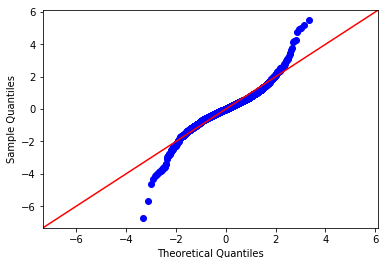

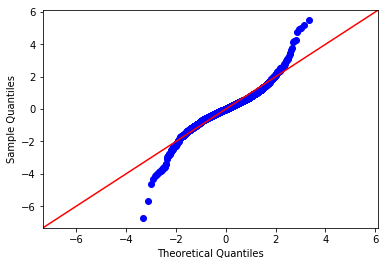

In [30]:
sm.graphics.gofplots.qqplot(np.array(y), dist=scipy.stats.norm, distargs=(), fit=True, line="45")

In [31]:
import matplotlib.pyplot as plt
gamma_model = sm.api.GLM(y, X, family=sm.api.families.Gamma())

/home/andylane/Envs/MetAP/lib/python3.6/site-packages/statsmodels/genmod/generalized_linear_model.py:244: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  DomainWarning)


In [32]:
print(labels[24])
print(labels[45])
print(labels[89])
print(labels[96])
print(labels[97])
print(labels[104])

++~~
+-~+
+po~
+p~-
+p~o
+~+~


In [33]:
list(labels).index("pppp")

468

In [34]:
np.sum(X, axis=0).max()

1042

In [42]:
X = X.astype(np.int32)

In [43]:
np.isnan(X).any()


False

In [44]:
type(X[0][0])

numpy.int32

In [35]:
gamma_results = gamma_model.fit()
print(gamma_results.summary())

/home/andylane/Envs/MetAP/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:124: RuntimeWarning: overflow encountered in square
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/andylane/Envs/MetAP/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:530: RuntimeWarning: invalid value encountered in true_divide
  weights = weights / np.sum(weights) * nobs
/home/andylane/Envs/MetAP/lib/python3.6/site-packages/statsmodels/genmod/families/links.py:301: RuntimeWarning: divide by zero encountered in power
  return np.power(z, 1. / self.power)
/home/andylane/Envs/MetAP/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:675: RuntimeWarning: invalid value encountered in true_divide
  return 2*np.sum(freq_weights*((endog-mu)/mu-np.log(endog_mu)))
/home/andylane/Envs/MetAP/lib/python3.6/site-packages/statsmodels/genmod/generalized_linear_model.py:655: RuntimeWarning: invalid value encountered in true_divide
  self.family.variance(mu))).

ValueError: On entry to DLASCL parameter number 4 had an illegal value

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe3d77c0da0>]],
      dtype=object)

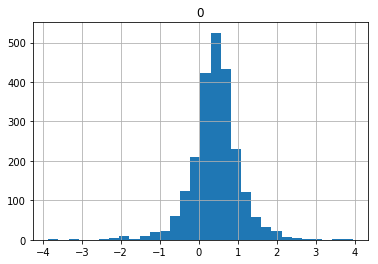

In [36]:
pandas.DataFrame(y).hist(bins = 30)

In [ ]:
zip()

In [ ]:
sm.graphics.gofplots.qqplot(gamma_results.resid_response, dist=scipy.stats.norm, distargs=(), fit=True, line="45")

In [400]:
p = gamma_results.pvalues[np.argpartition(gamma_results.pvalues, 20)[:20],]

In [401]:
l = labels[np.argpartition(gamma_results.pvalues, 20)[:20],]

In [402]:
c = gamma_results.params[np.argpartition(gamma_results.pvalues, 20)[:20],]

In [403]:
#The count of observations of a given motif
count_ = np.sum(X, axis=0)[np.argpartition(gamma_results.pvalues, 20)[:20],]

In [404]:
np.sum(X, axis=0)[np.argpartition(gamma_results.pvalues, 20)[:20],]

array([ 12,  41,  12,  99,  43,  39,  18,  26,  26,  42,  49,  19,  26,
        36,  90,  39, 104,  10, 298,  21], dtype=int64)

In [405]:
motif_summary = pandas.DataFrame(list(zip(l, c, p, count_)))

In [406]:
motif_summary.columns = ["motif", "coefficient", "p-value", "count of obs"]

In [411]:
gamma_model.exog

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [409]:
gamma_model.predict(X.transpose())

array([[12.,  0.,  0., ...,  2.,  2.,  0.],
       [ 0., 12.,  1., ...,  0.,  0.,  1.],
       [ 0.,  1., 12., ...,  0.,  0.,  1.],
       ...,
       [ 2.,  0.,  0., ..., 20.,  0.,  0.],
       [ 2.,  0.,  0., ...,  0., 12.,  0.],
       [ 0.,  1.,  1., ...,  0.,  0., 12.]])

In [407]:
motif_summary

,motif,coefficient,p-value,count of obs
0,+p-~,-1.117492,0.000322,12
1,~p+~,-0.635022,0.009116,41
2,o-+~,1.459938,0.004041,12
3,~~pp,0.438525,0.010326,99
4,~op~,0.708046,0.004080,43
5,o-po,0.766910,0.006329,39
6,oo-+,-1.627657,0.000712,18
7,oo-p,-1.159522,0.000733,26
8,ooo-,0.858248,0.010839,26
9,-poo,-0.635072,0.008994,42


In [232]:
proteins[0].summ

'p-~o-~ppp+o~--po~oop~o~ooo+op~ppoopop-p--pppo+o+ppp~-oppo+pp+o+pppo~p~~p~p-pp+opppp~p+ppop+-o-+~opp-p~oopppo---ppo++o+p-ppp++pp-po~pp+poooop~po-oo-popp-+po~pppo-p+p~po++po-p~+oo~~~p+ppop-p+~ppo+pp~-p~--p-pp-oo~--~+-pppoopoopo~~ppo~p-o+~++p-o~oppop+-po~po~po~opoopoppo~popop~-oo-p-~pp+~~pppop+o~+oppp-op-+op++~+~ppp-poo~-p~p-p+oppppp-opo-+po++~op~~oo-o--pp+ppoopo-op--+~-pop-pp+ppopopo~ppo~ppppp~~ppoo-pp+ppo~+po~p~opppp-pp-pp-op~+~-~--pp~+~-+p-pp+p~p~-op~o+poopopppp~~~pp~~-pp+opppp~p~oo+-+~ppopo-~-pp-+oopo+oppp+~++po+~+opopp-pop+pooop+p-p+po+p~~oo-oppo--ppo+o-pppopp-op-p++pp-o+~ppop+~pp-o~op~o+~+o-ppp~+po-opoo++-~~---p~p~op+op~ppp-+opopp+-+p-oopo++~oppo+ppoopoop--ppo+poo~+op-~~popp+ppo++~+opoo~p-pp+p+p-+ppo++ppopp+~p~p-p+p+-~opppoo~++~~o~p+p-po-~p+poppoopp+pppopp~p~pp---pop-pppoppo-p+po-p+~oo+ppoo--op++~-+p~poo---+opppop-+pppoo-po+o-poppppop-+---+o~+p-ppoppoop+p+ppop-~p-+p+o++pp~+pp~pppooopopo~pppp-pp+po~~p~p-pp+o~ppoppp~ppppo-oo-p++o+p+o~popopp-+pop+~+--popp-ppopp+-+p~p-~opppo~p+pppp~pp~

In [ ]:
gamma_results.pearson_chi2

In [ ]:
scipy.stats.chi2.isf(0.05, 4443)

In [ ]:
import statsmodels

In [ ]:
# Raw data against a Poisson distribution
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
data=np.random.poisson(10, 1000)
stats.probplot(np.array(y), dist='poisson', sparams=(100,), plot=plt)
plt.show()

Data are overdispersed - variance far larger than mean

In [ ]:
print(np.var(y))
print(np.mean(y))

### What have I learned?
- How to fit a generalized linear model
- A lot about data imputation (MICE vs means vs dropping vs adding a 1 to count data)
- Picking a distribution and plotting residuals on a qq plot
- Learned a bit about p values in a GLM model, but still need to figure out if having a single "good" p value means a single kmer/factor is significant in predicting abundance



- Mass spec stuff: LFQ vs iBAQ and razor peptides


- Got much better at Pandas indexing
- Understand a lot 
- A lot about binarizing count data

To do next: debug why all samples have same normalized iBAQ data above